#Load & Inspect the Dataset

##Load & Inspect

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Portfolio X/Fraud Detection & Anomaly Analytics Engine/creditcard.csv')

# Basic info
print(df.shape)
print(df.head())
print(df['Class'].value_counts())  # Check imbalance

(284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V

##Basic Cleaning

In [ ]:
# Check for nulls
print(df.isnull().sum())

# Rename columns if needed (optional)
df.rename(columns={'Class': 'Fraud'}, inplace=True)

# Scale 'Amount' and 'Time'
from sklearn.preprocessing import StandardScaler

df['scaled_amount'] = StandardScaler().fit_transform(df[['Amount']])
df['scaled_time'] = StandardScaler().fit_transform(df[['Time']])
df.drop(['Amount', 'Time'], axis=1, inplace=True)

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


##Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('Fraud', axis=1)
y = df['Fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


#Isolation Forest – Unsupervised Anomaly Detection

##Train Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

# Fit model on training data (without using class labels!)
iso_forest = IsolationForest(n_estimators=100, contamination=0.0017, random_state=42)
iso_forest.fit(X_train)

# Predict anomalies: -1 = anomaly, 1 = normal
preds = iso_forest.predict(X_test)

# Convert to 0 (normal), 1 (anomaly)
preds = [1 if p == -1 else 0 for p in preds]

##Evaluate Against Actual Labels

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
print("\nClassification Report:\n", classification_report(y_test, preds, digits=4))

Confusion Matrix:
 [[56792    72]
 [   66    32]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9988    0.9987    0.9988     56864
           1     0.3077    0.3265    0.3168        98

    accuracy                         0.9976     56962
   macro avg     0.6533    0.6626    0.6578     56962
weighted avg     0.9977    0.9976    0.9976     56962



##Risk Score

In [ ]:
# Decision function gives anomaly score (lower = more anomalous)
risk_scores = iso_forest.decision_function(X_test)

# Convert to probabilities (optional normalization)
import numpy as np
normalized_scores = np.interp(risk_scores, (risk_scores.min(), risk_scores.max()), (1, 0))

# Add to test DataFrame
results_df = X_test.copy()
results_df['Actual'] = y_test
results_df['Predicted'] = preds
results_df['RiskScore'] = normalized_scores

#Local Outlier Factor (LOF) for Anomaly Detection

In [ ]:
from sklearn.preprocessing import StandardScaler

# Drop the target column (Fraud)
X = df.drop(columns=['Fraud'])
y = df['Fraud']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix

# Drop labels for unsupervised training
X_lof = X_scaled.copy()

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.0017, novelty=False)

# Predict: -1 = outlier, 1 = inlier
y_pred_lof = lof.fit_predict(X_lof)

# Convert to match our binary fraud format
y_pred_binary = [1 if x == -1 else 0 for x in y_pred_lof]

# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y, y_pred_binary))
print("\nClassification Report:\n", classification_report(y, y_pred_binary))

results_df = df.copy()
results_df['LOF_Pred'] = y_pred_binary

Confusion Matrix:
 [[283830    485]
 [   492      0]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.00      0.00      0.00       492

    accuracy                           1.00    284807
   macro avg       0.50      0.50      0.50    284807
weighted avg       1.00      1.00      1.00    284807



#Isolation Forest Model (Unsupervised)

##Train Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

# Isolation Forest expects no labels
iso_forest = IsolationForest(n_estimators=100, contamination=0.0017, random_state=42)
y_pred_iso = iso_forest.fit_predict(X_scaled)

# Convert output to fraud label
y_pred_iso_binary = [1 if x == -1 else 0 for x in y_pred_iso]

# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y, y_pred_iso_binary))
print("\nClassification Report:\n", classification_report(y, y_pred_iso_binary))

# Save predictions
results_df['IF_Pred'] = y_pred_iso_binary

Confusion Matrix:
 [[283965    350]
 [   357    135]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.28      0.27      0.28       492

    accuracy                           1.00    284807
   macro avg       0.64      0.64      0.64    284807
weighted avg       1.00      1.00      1.00    284807



#Explainability with SHAP

##Use SHAP on Isolation Forest

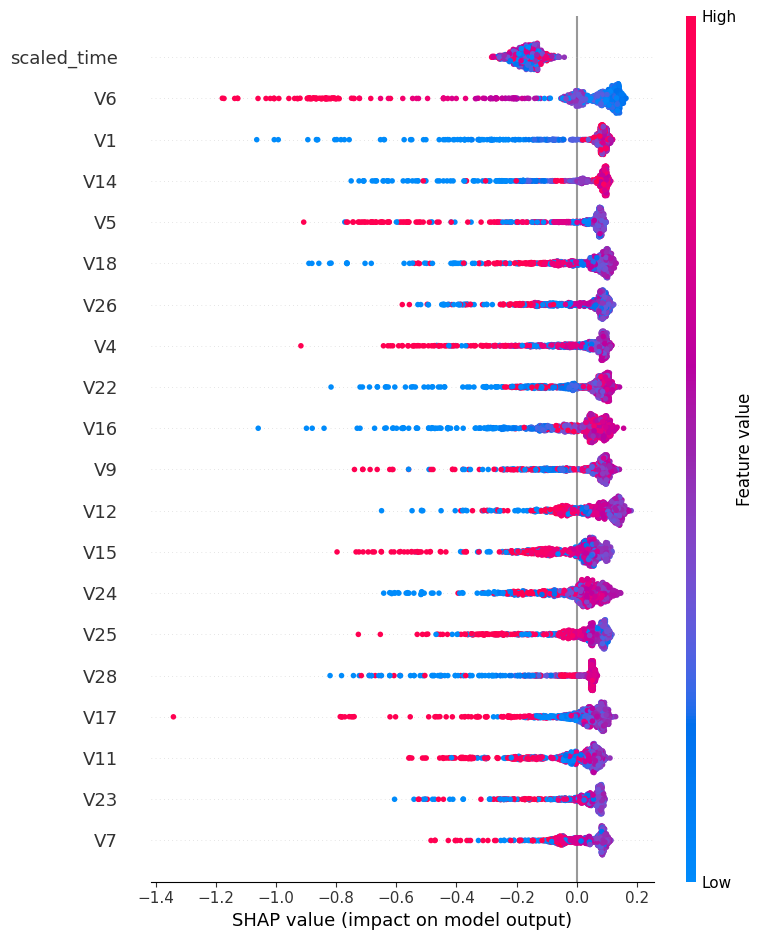

In [ ]:
import shap

# Train a tree explainer
explainer = shap.Explainer(iso_forest)
shap_values = explainer(X_scaled[:1000])

# Plot summary
shap.summary_plot(shap_values, X_scaled[:1000], feature_names=X.columns)

#Autoencoder Model

In [ ]:
!pip install tensorflow

##Import Required Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

##Define & Train Autoencoder

In [ ]:
# Use the same scaled input features
X_auto = X_scaled.copy()

# Define autoencoder architecture
input_dim = X_auto.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(14, activation='relu')(input_layer)
encoded = Dense(7, activation='relu')(encoded)
decoded = Dense(14, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
autoencoder.fit(X_auto, X_auto, epochs=10, batch_size=256, shuffle=True, validation_split=0.1, verbose=1)


Epoch 1/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.8848 - val_loss: 0.6648
Epoch 2/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.6399 - val_loss: 0.6137
Epoch 3/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5830 - val_loss: 0.5930
Epoch 4/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5588 - val_loss: 0.5831
Epoch 5/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5487 - val_loss: 0.5772
Epoch 6/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5400 - val_loss: 0.5691
Epoch 7/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.5336 - val_loss: 0.5705
Epoch 8/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5259 - val_loss: 0.5593
Epoch 9/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5119 - val_loss: 0.5534
Epoch 10/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5121 - val_loss: 0.5490


##Reconstruction Error & Thresholding

In [ ]:
# Get reconstruction loss
reconstructions = autoencoder.predict(X_auto)
mse = np.mean(np.power(X_auto - reconstructions, 2), axis=1)

# Set threshold (manually or by quantile)
threshold = np.quantile(mse, 0.995)

# Predict fraud
y_pred_ae = [1 if e > threshold else 0 for e in mse]

# Evaluate
from sklearn.metrics import confusion_matrix, classification_report
print("Confusion Matrix (Autoencoder):\n", confusion_matrix(y, y_pred_ae))
print("\nClassification Report (Autoencoder):\n", classification_report(y, y_pred_ae))

# Add predictions to result dataframe
results_df['Autoencoder_Pred'] = y_pred_ae

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
Confusion Matrix (Autoencoder):
 [[282972   1343]
 [   410     82]]

Classification Report (Autoencoder):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.06      0.17      0.09       492

    accuracy                           0.99    284807
   macro avg       0.53      0.58      0.54    284807
weighted avg       1.00      0.99      1.00    284807



##Save the model for Streamlit

In [ ]:
autoencoder.save("/content/drive/MyDrive/Portfolio X/Fraud Detection & Anomaly Analytics Engine/autoencoder_model.h5")

#Final Evaluation & Model Score Aggregation

##Evaluate Autoencoder Predictions

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate
print("Confusion Matrix (Autoencoder):\n", confusion_matrix(y, y_pred_ae))
print("\nClassification Report (Autoencoder):\n", classification_report(y, y_pred_ae))

Confusion Matrix (Autoencoder):
 [[282972   1343]
 [   410     82]]

Classification Report (Autoencoder):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.06      0.17      0.09       492

    accuracy                           0.99    284807
   macro avg       0.53      0.58      0.54    284807
weighted avg       1.00      0.99      1.00    284807



##Aggregate Scores into results_df

In [ ]:
results_df['Autoencoder_Pred'] = y_pred_ae

##Export All Models + Predictions for Streamlit

In [ ]:
import joblib

# Save all models
joblib.dump(y_pred_iso_binary, '/content/drive/MyDrive/Portfolio X/Fraud Detection & Anomaly Analytics Engine/isolation_forest_model.pkl')
joblib.dump(y_pred_ae, '/content/drive/MyDrive/Portfolio X/Fraud Detection & Anomaly Analytics Engine/autoencoder_model.h5')
joblib.dump(scaler, '/content/drive/MyDrive/Portfolio X/Fraud Detection & Anomaly Analytics Engine/scaler.pkl')

# Save final dataset with predictions
results_df.to_csv('/content/drive/MyDrive/Portfolio X/Fraud Detection & Anomaly Analytics Engine/final_fraud_predictions.csv', index=False)